### **ChatGPT MWP performance prediction**
The emergence of large language models (LLMs) have gained much popularity in recent years, with OpenAI's GPT-3 series models being considered as the state-of-the-art. In particular, the variant of GPT-3 tuned for natural dialog, known as ChatGPT, has gathered much popular interest. However, LLMs have known performance issues, 
specifically when reasoning tasks are involved. This project aims to investigate aspects of math word problems (MWPs) that can indicate the success or failure of ChatGPT on such problems.
  
In this notebook in particular, we attempt to predict ChatGPT's performance on specific questions in DRAW-1K using classifiers by extracting equations from ChatGPT's response.  
  

### **Download libraries**
In order to replicate the results produced in this notebook, it is recommended to use the exact version of Python as well as the exact versions of each library.  
We first download the libraries that will be used in this notebook. We specify the exact version of each library to download.

In [677]:
%%capture

# =========================================== #
#               Requirements
# ------------------------------------------- #
# - Python 3.7.9
# =========================================== #

%pip install nltk==3.8.1
%pip install pandas==1.3.5
%pip install sympy==1.10.1
%pip install plotly==5.13.0
%pip install xgboost==1.6.2

# %pip install xlsxwriter==3.0.9
# %pip install scikit-learn==1.0.2
# %pip install beautifulsoup4==4.11.2
# %pip install torch==1.13.1
# %pip install transformers==4.27.4
# %pip install tqdm==4.64.1

### **Load libraries**

In [678]:
# =========================================== #
#                Libraries
# =========================================== #

# ------------------------------------------- #
#   Python
# ------------------------------------------- #
import re
import os
import ast
import sys
import threading
from time import sleep

try:
    import thread
except ImportError:
    import _thread as thread

# ------------------------------------------- #
#   Pandas
# ------------------------------------------- #
import pandas
pandas.options.display.max_rows = 4000

# ------------------------------------------- #
#   Plotly
# ------------------------------------------- #
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# ------------------------------------------- #
#   Sympy
# ------------------------------------------- #
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import transformations
from sympy.parsing.sympy_parser import T
from sympy import Eq
from sympy import solve

# ------------------------------------------- #
#   Sklearn
# ------------------------------------------- #
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# ------------------------------------------- #
#   Matplotlib
# ------------------------------------------- #
import matplotlib.pyplot as plt

# ------------------------------------------- #
#   XGBoost
# ------------------------------------------- #
from xgboost import XGBClassifier

# ------------------------------------------- #
#   Tensorflow
# ------------------------------------------- #
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

# ------------------------------------------- #
#   Seaborn
# ------------------------------------------- #
import seaborn

### **Constants**
Here, we configure values required one run through of the contents in the notebook.   
This should be the only part of the notebook you would have to change from run-to-run.

In [679]:
RESPONSE_FILE_PATH = '../data/hwelsters__gpt-3.5-turbo__v001 (prefix__system_of_equations).jsonl'
QUESTION_FILE_PATH = '../data/draw.json'
TEST_SIZE = 0.02
RANDOM_STATE = 42
N_SPLITS = 5
VISUALIZE_DATA = True

### **Load data**

In [680]:
# =========================================== #
#                Load data
# =========================================== #

# ------------------------------------------- #
#   Functions which loads data into
#   a dataframe based on its file extension
#   Currently accepts .json, .jsonl, .csv
# ------------------------------------------- #
def load_file(path, usecols):
    split_path = os.path.splitext(path)
    file_extension = split_path[-1]

    data = pandas.DataFrame()
    if file_extension == '.json': data = pandas.read_json(path)
    if file_extension == '.jsonl': data = pandas.read_json(path, lines=True)
    if file_extension == '.csv': data = pandas.read_csv(path)

    return data.columns, data


# ------------------------------------------- #
#   Helper function that loads data stored in 
#   a file at a particular file-path into a 
#   pandas dataframe, extracting only the 
#   columns specified.
# ------------------------------------------- #
def load_data(path, sample_size=5, columns=None, label=None):
    available_columns, dataframe = load_file(path, columns)
    if columns != None: available_columns = list(set(columns).intersection(available_columns))
    return dataframe[available_columns]

In [681]:
# =========================================== #
#           Load ChatGPT's response
# ------------------------------------------- #
# Loads data from input file into a dataframe
# =========================================== #
responses_df = load_data(RESPONSE_FILE_PATH)
responses_df.head()

,model,temperature,max_tokens,date_time,question_number,question,system_text,response,prompt_tokens,completion_tokens,total_tokens
0,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:11,5,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'a + c = 34',\n '8...",365,203,568
1,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,36,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'C = 2G',\n '...",352,176,528
2,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,16,\nProvide a solution to the following problem ...,None,"{\n 'num_of_unknowns': 2,\n 'num_of_addi...",367,197,564
3,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,9,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'a - b = 36',\n 'a...",342,186,528
4,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,6,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'R=1/5',\n 'C=1/6'...",361,240,601


In [682]:
# =========================================== #
#         Load ground truth dataset
# ------------------------------------------- #
# Loads data from input file into a dataframe
# =========================================== #
ground_truth_df = load_data(QUESTION_FILE_PATH)
ground_truth_df.head()

,sQuestion,lSolutions,Template,lEquations,iIndex,Alignment,Equiv
0,Juniors boat will go 15 miles per hour in stil...,[2.14285714286],[a * m + b * m = b * c - a * c],[12*(15-x)=9*(15+x)],397760,"[{'coeff': 'a', 'SentenceId': 1, 'Value': 9.0,...",[]
1,A factory makes three-legged stools and four-l...,"[83.0, 78.0]","[a * m + b * n = c, m + n = d]","[student+general=161, 3*student+4*general=566]",327651,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 3.0,...",[]
2,a bank offers two checking plans . The anywher...,[14.0],[0.01 * a * m - 0.01 * b * m = c],[(.01*30)*x=(.01*22)*x+1.12],238992,"[{'coeff': 'a', 'SentenceId': 1, 'Value': 30.0...",[]
3,The student-teacher ratio for Washington High ...,[1155.0],[a * m = b * c],[27.5*42=x*1],40964,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 1.0,...",[]
4,"Mike 's age , decreased by the age of his 4 ye...","[38.0, 15.0]","[m = a + b, m + n = c]","[y-4=11, y+x=53]",936363,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 4.0,...",[]


### **Convert ChatGPT's JSON response to dict**
ChatGPT will return its answer in JSON form. We will extract the information we require and convert it to dict form.

In [683]:
# =========================================== #
#  Functions for checking ChatGPT's response
# =========================================== #

# ------------------------------------------- #
#   Function to fix ChatGPT's json,
#   Removes comments (e.g '// Comment' --> '')
#   ' symbol if it is between letters (e.g 'Abhinav's' --> 'Abhinavs')
# ------------------------------------------- #
def fixjson(badjson):
    badjson = re.sub(r'\/\/.*\n', '\n', badjson)
    badjson = re.sub(r'([a-zA-Z])\'([a-zA-Z])', '', badjson)
    return badjson

# ------------------------------------------- #
#   Extracts decimals from ChatGPT's str 
#   response. 
#   
#   If ChatGPT's JSON is incorrectly or 
#   unexpectedly formatted, returns "FAILED"
# ------------------------------------------- #
def extract_json(text : str, question_number):
    ret = ""
    try:
        ret = re.findall(r'\{.*\}', text, re.DOTALL)[0]
        ret = fixjson(ret)
        body = ast.literal_eval(fixjson(ret))
        body['question_number'] = question_number
        return body
    except Exception as Argument: 
        return "FAILED"

In [684]:
extracted_json_val = responses_df.apply(lambda x : extract_json(x['response'], x['question_number']), axis=1)
extracted_json_val = extracted_json_val[extracted_json_val!='FAILED'].to_list()
extracted_json_val = pandas.DataFrame(extracted_json_val)
extracted_json_val.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN


### **Solve system of equations**
ChatGPT's response will consist of a system of equations. We solve this system of equations so we can compare ChatGPT's final answer to the correct answer.

In [685]:
# ------------------------------------------- #
#   This function standardizes ChatGPT's 
#   equations.
#   
#   e.g 'tons of hay + tons of wheat = 10'
#       --> a + b = 10
#   
#   In some cases, ChatGPT returns a
#   dict of equations
#   In this case, we just get the values or 
#   the keys of this dictionary depending on 
#   which one has an equal sign
# ------------------------------------------- #
def canonicalize_equations(texts):  
    # If ChatGPT did not give equations at all, return None
    if (str(texts) == "nan"): return None

    # CHATGPT sometimes gives equations as dictionaries rather than arrays. 
    # As such, we do this instead
    
    if type(texts) is dict: 
        new_texts = []
        for text in texts.values(): 
            if str(text).count('=') > 0: new_texts.append(text)
        for text in texts.keys(): 
            if str(text).count('=') > 0: new_texts.append(text)
        texts = new_texts

    if type(texts) is list and len(texts) > 0:
        new_texts = []
        for text in texts:
            if type(text) is dict:
                for t in text.values(): 
                    if str(t).count('=') > 0: new_texts.append(t)
                for t in text.keys(): 
                    if str(t).count('=') > 0: new_texts.append(t)
            elif type(text) is str: new_texts.append(text)
        texts = new_texts
        # print("NEW TEXT: ", texts)
    
    # Converts it all to a list of str
    if type(texts) is set: texts = list(texts)
    texts = [str(text) for text in texts]


    A_CODE = 97
    letters = {}
    index = A_CODE

    new_texts = []
    for text in texts:
        if type(text) is dict:
            text = text[list(text.values())[0]]
        new_texts.append(text)
    texts = new_texts


    REP = '[supadupaepicstonkifiers]'
    for text in texts:
        text = str(text)
        text = text.replace('+', REP)
        text = text.replace('-', REP)
        text = text.replace('*', REP)
        text = text.replace('=', REP)
        text = text.replace('(', REP)
        text = text.replace(')', REP)
        text = text.replace('{', REP)
        text = text.replace('}', REP)
        text = text.replace(',', '')
        text = text.replace('/', REP)
        text = text.replace('.', REP)

        spl = text.split(REP)

        for text in spl:
            text = text.strip() 
            while len(text) > 0 and text[0].isdigit(): text = text[1:]
            if len(text) > 0 and not text in letters.keys(): 
                letters[text] = chr(index)
                index += 1
    
    to_return = []

    def get_len(key):
        return -len(key[0])

    test_dict_list = list(letters.items())
    test_dict_list.sort(key = get_len)

    letters = {ele[0] : ele[1]  for ele in test_dict_list}

    # Canonicalizes the equation variable names
    for text in texts:
        for swap in letters.keys():
            text = text.replace(swap, letters[swap])
        to_return.append(text)

    return to_return

extracted_json_val["canonicalized_equations"] = extracted_json_val["equations"].apply(lambda row : canonicalize_equations(row))
extracted_json_val.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]"
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]"
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]"
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]"
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a..."


In [686]:
# ------------------------------------------- #
#   A function for creating a SymPy 
#   expressions
# ------------------------------------------- #
def create_expression(text):
    print(text)
    split_text = text.split('=')
    return Eq(parse_expr(split_text[0], transformations=T[:6]), parse_expr(split_text[1], transformations=T[:6]))

def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

# ------------------------------------------- #
#   A function that times out functions 
#   after a certain period of time
# ------------------------------------------- #
def exit_after(s):
    '''
    use as decorator to exit process if 
    function takes longer than s seconds
    '''
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

# ------------------------------------------- #
#   Solves a system of equations given in
#   a list of str
# ------------------------------------------- #
@exit_after(5)
def solve_system(equations):
    try:
        expressions = [create_expression(equation) for equation in equations]
        return solve(expressions)
    except:
        return {}

extracted_json_val["solved_ans"] = extracted_json_val.apply(lambda row : solve_system(row["canonicalized_equations"]), axis=1)
extracted_json_val.head()

a + b = 34
8a + 5b = 236
a = 2b
a - 9 = 5(b - 9)
a + b = c/6
a = b + 24
a - b = 36
a + b = 62
a=1/5
b=1/6
c=1/d
a*c + b*c=1
d =(1) / (a + b)
a + 6 = 4a - 30
3a = 36
a = 12
a = 3b
a + b = 52
a + b = -42
a - b = 52
a = 2b + 4
a + b = 25
508 = 6a + 70
a + 2b = 2860
2a + b = 2990
a + b = 9
10b + a = 6(a + b)
a = 54,150 + 12.50b
25a = b*25a
a + b = 13
a = 2b + 1
a = b
a + (a+9) = 19
a + b = 24
16a + 9b = 258
a = b + 7
a + b = 27
3a + 4b = 566
a + b = 161
a + b = 88
a = 5b + 10
a = 1.12 + 0.22b
c = 0.3b
19 + 4a = 166 - 3a
125 - a = 6(80 - a)
125 - a = 480 - 6a
5a = 355
a = 71
a + b = 40
0.25a + 0.50b = 0.45*40
a - b = 16
3a = 9b
a + b = 6000
0.09a + 0.11b = 624
a + 0.04a = 1058.30
1.04a = 1058.30
3a + b = 14
2a - b = 1
a = 3b
a + 20 = b + 6
a + b = 17
b = 3a
a + b = 7
21a + 14b = 119
a + b = 28
0.05a + 0.10b = 2.60
a = 1/4
b = 1/6
a + b = 1/c
a + b = 55
a - b = -9
a = b
c = d
0.35a + 0.15c = 2640
a + 2600 = c
0.35(a + 2600) + 0.15a = 2640
10a + b = 3(10b + a) + 6
a = b + 4
a + b = 140
a - b 

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations,solved_ans
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}"
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}"
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}"
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}"
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[]


In [687]:
extracted_json_val.head(5)

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations,solved_ans
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}"
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}"
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}"
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}"
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[]


In [688]:
# ------------------------------------------- #
#   A function that extracts decimal numbers
#   from string
# ------------------------------------------- #
def extract_decimals(response : str):
    response = str(response)
    pattern = r'\d+(?:\.\d+)?'
    decimals = re.findall(pattern, response)
    return set(decimals)

extracted_json_val["extracted_solved_ans"] = extracted_json_val.apply(lambda row : extract_decimals(row["solved_ans"]), axis=1)
extracted_json_val["extracted_final_answer"] = extracted_json_val.apply(lambda row : extract_decimals(row["final_answer"]), axis=1)
extracted_json_val["final_solved_same"] = extracted_json_val.apply(lambda row : 1 if row["extracted_final_answer"].issubset(row["extracted_solved_ans"])  else 0, axis=1)
extracted_json_val.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations,solved_ans,extracted_solved_ans,extracted_final_answer,final_solved_same
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}","{12, 22}",{18},0
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}","{24, 12}",{36},0
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}",{12},"{87, 63}",0
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}","{13, 49}","{13, 49}",1
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[],{},"{30, 2}",0


### **Evaluate ChatGPT's response**
We compare ChatGPT's response to the actual solution and observe how well ChatGPT fared.

In [689]:
# ------------------------------------------- #
#   A helper function for comparing  
#   ChatGPT's response to the actual solution
# ------------------------------------------- #
def evaluate_response(actual_solution, response_solution, transform_func):
    actual_solution = [transform_func(float(solution)) for solution in actual_solution]
    response_solution = [transform_func(float(solution)) for solution in response_solution]

    actual_solution = set(actual_solution)
    response_solution = set(response_solution)
    
    if actual_solution.issubset(response_solution): return "all"
    elif actual_solution.intersection(response_solution): return "some"
    else: return "none"
    
# ------------------------------------------- #
#   Check ChatGPT's response without any 
#   transformations
# ------------------------------------------- #
def check_normal(actual_solution, response_solution):
    return evaluate_response(actual_solution, response_solution, lambda x : x)

# ------------------------------------------- #
#   Check ChatGPT's response when rounded
# ------------------------------------------- #
def check_rounded(actual_solution, response_solution):
    return evaluate_response(actual_solution, response_solution, lambda x : round(x, 1))

evaluated_df = extracted_json_val
evaluated_df['normal_correct'] = evaluated_df.apply(lambda row : check_normal(ground_truth_df.loc[row["question_number"]]["lSolutions"], list(row["extracted_final_answer"])), axis=1)
evaluated_df['rounded_correct'] = evaluated_df.apply(lambda row : check_rounded(ground_truth_df.loc[row["question_number"]]["lSolutions"], list(row["extracted_final_answer"])), axis=1)


# ------------------------------------------- #
#   We also create the y value for prediction
# ------------------------------------------- #

answer_map = {"all": 1, "some" : 1, "none": 0}
evaluated_df['is_correct'] = evaluated_df.apply(lambda row : answer_map[row["normal_correct"]], axis=1)
evaluated_df.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,...,question_number,num_of_multiplication,canonicalized_equations,solved_ans,extracted_solved_ans,extracted_final_answer,final_solved_same,normal_correct,rounded_correct,is_correct
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],...,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}","{12, 22}",{18},0,none,none,0
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],...,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}","{24, 12}",{36},0,none,none,0
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",...,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}",{12},"{87, 63}",0,none,none,0
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",...,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}","{13, 49}","{13, 49}",1,all,all,1
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",...,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[],{},"{30, 2}",0,none,none,0


### **ChatGPT's stats**
We observe how well ChatGPT has done

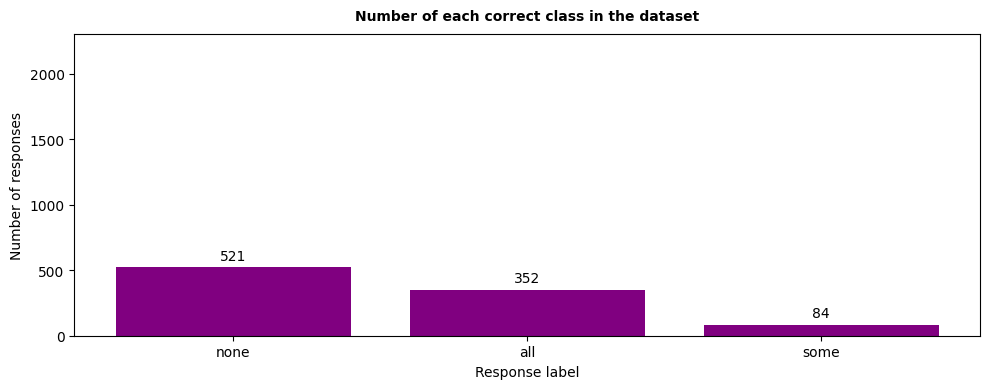

In [690]:
# =========================================== #
#    Visualize normal data
# =========================================== #

if VISUALIZE_DATA:
       fig, ax = plt.subplots(1, 1, figsize=(10, 4))

       # Distribution by class
       ax.bar(x = evaluated_df['rounded_correct'].unique(), # Data labels
              height = evaluated_df['rounded_correct'].value_counts().values, # Num of tweets in each category
              color='purple')

       ax.bar_label(ax.containers[0], label_type='edge', padding=3) # Annotate bars
       ax.set_ylim(0, 2300) # Raise upper limit of y-axis, to accommodate labels

       ax.set_title("Number of each correct class in the dataset", 
              fontweight='bold', fontsize=10, y = 1.02)
       ax.set_ylabel("Number of responses")
       ax.set_xlabel('Response label')

       plt.tight_layout()
       plt.show()

In [691]:
model_df = evaluated_df[[
    "num_of_unknowns", 
    "num_of_additions", 
    "num_of_subtractions", 
    "num_of_multiplications", 
    "num_of_divisions", 
    "num_of_equations", 
    "num_of_parentheses", 
    "difficulty",
    "final_solved_same",
    "is_correct",
]]
model_df = model_df.dropna()
print("Dataframe LEN:" + str(len(model_df)))
model_df.head()

Dataframe LEN:946


,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,difficulty,final_solved_same,is_correct
0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0,0
1,2.0,1.0,2.0,1.0,0.0,2.0,2.0,4.0,0,0
2,2.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0,0
3,2.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1,1
4,3.0,2.0,0.0,0.0,1.0,2.0,2.0,4.0,0,0


### **Pearson Correlation Heatmap**
We generate some correlation plots of the features to observe correlations between various mathematical features

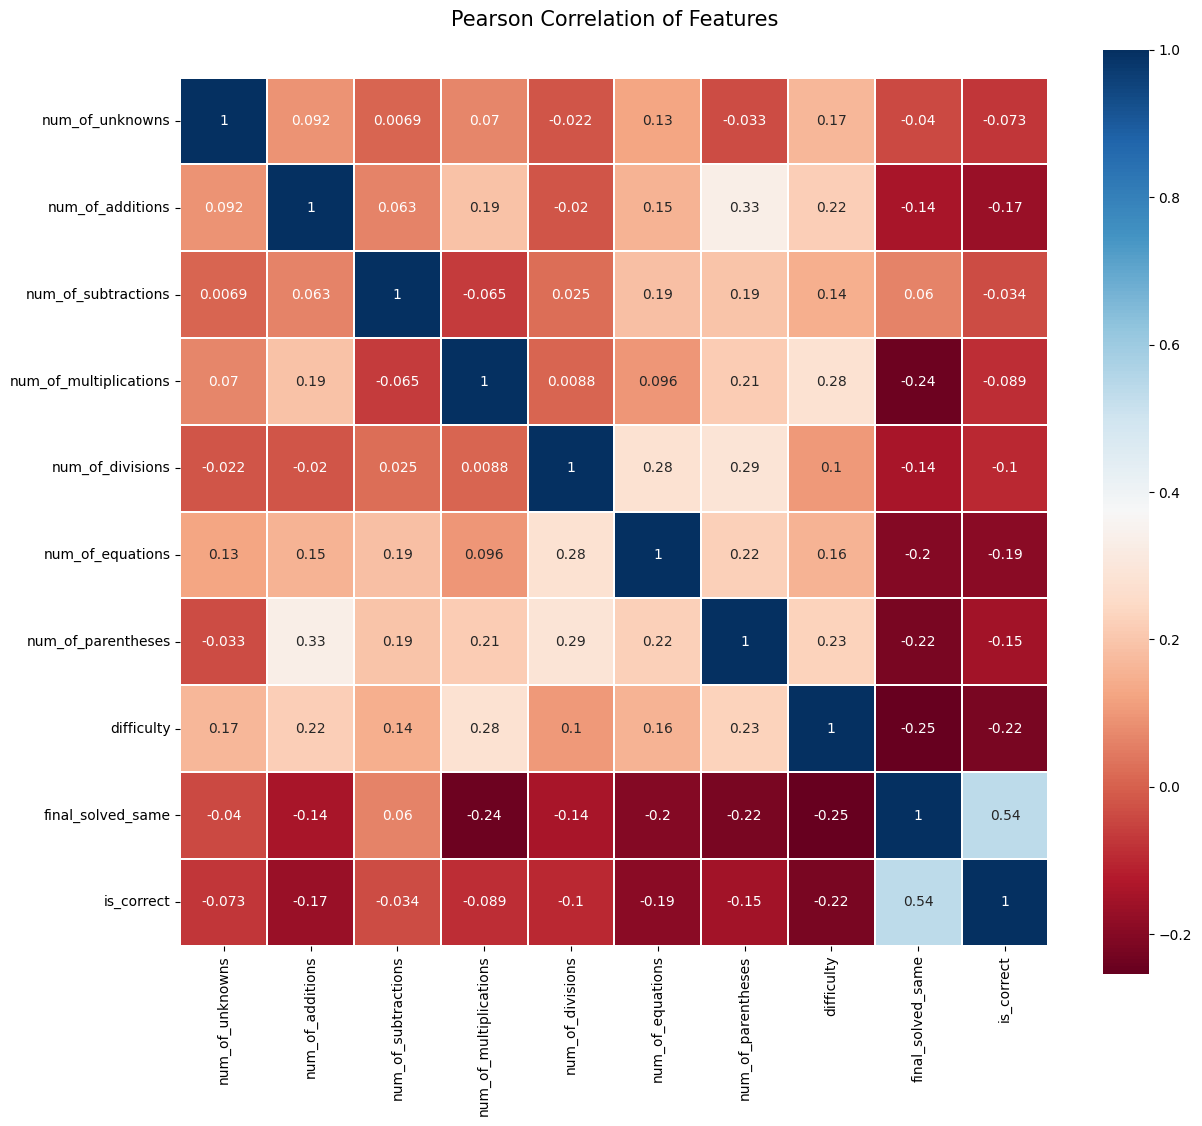

In [692]:
if VISUALIZE_DATA:
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    seaborn.heatmap(model_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)

### **Scatter plot matrix**

In [693]:
if VISUALIZE_DATA:
    fig = px.scatter_matrix(evaluated_df,
                            dimensions=[
                                "num_of_unknowns",
                                "num_of_additions",
                                "num_of_subtractions",
                                "num_of_multiplications",
                                "num_of_divisions",
                                "num_of_equations",
                                "num_of_parentheses",
                                "difficulty",
                                "final_solved_same"],
                            color="normal_correct")
    fig.update_layout(
        title='ChatGPT response',
        dragmode='select',
        width=1600,
        height=1600,
        hovermode='closest',
    )
    fig.show()


In [694]:
labels = list(model_df.columns.drop(labels=['is_correct']))
groups = model_df.groupby(labels)['is_correct'].mean()
overlap = model_df.groupby(labels).filter(lambda x: not(x['is_correct'].mean() == 1.0 or x['is_correct'].mean() == 0.0))

print("NUMBER OF GROUPS:", len(groups))
display(groups.head(5))
print("NUMBER OF OVERLAP:", len(overlap))
display(overlap.head(5))

NUMBER OF GROUPS: 624


num_of_unknowns  num_of_additions  num_of_subtractions  num_of_multiplications  num_of_divisions  num_of_equations  num_of_parentheses  difficulty  final_solved_same
1.0              0.0               0.0                  0.0                     0.0               1.0               0.0                 2.0         0                    1.0
                                                                                                  3.0               0.0                 3.0         0                    0.0
                                                                                3.0               1.0               0.0                 3.0         0                    0.0
                                                                                6.0               3.0               3.0                 3.0         0                    1.0
                                                        1.0                     0.0               3.0               0.0                 4.0   

NUMBER OF OVERLAP: 278


,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,difficulty,final_solved_same,is_correct
3,2.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1,1
6,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,1,1
7,2.0,1.0,1.0,0.0,0.0,2.0,0.0,5.0,1,0
8,2.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,1,1
13,2.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,1,1


### **Predict ChatGPT's success using ML models**
We attempt to predict ChatGPT's success in solving math word problems based on features extracted from its response.

#### **Split data into train and test sets**

In [695]:
train, test = train_test_split(model_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_x = train.drop(columns=["is_correct"])
test_x = test.drop(columns=["is_correct"])

train_y = train["is_correct"]
test_y = test[["is_correct"]]

display(train_x.head())
display(train_y.head())

,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,difficulty,final_solved_same
605,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1
879,1.0,1.0,0.0,2.0,2.0,2.0,2.0,3.0,0
940,2.0,3.0,2.0,2.0,0.0,2.0,4.0,5.0,0
791,2.0,1.0,0.0,2.0,0.0,2.0,2.0,4.0,0
844,1.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0


605    1
879    0
940    0
791    0
844    1
Name: is_correct, dtype: int64

### **Sklearn Helper**
This is just a utility class which wraps all needed functions for Sklearn models

In [696]:
# =========================================== #
#    Sklearn Helper
# =========================================== #
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params={}):
        self.clf = clf
        self.params = params

    def fit(self, x_train, y_train):
        self.fitted = self.clf(**self.params).fit(x_train, y_train)
    
    def predict(self, x):
        return self.fitted.predict(x)
    
    def feature_importance(self):
        return self.fitted.feature_importances_
    
    def tune(self, x_train, y_train, params=None):
        
        grid = GridSearchCV(self.clf(), param_grid=params)
        grid.fit(x_train, y_train)

        self.params = grid.best_params_

        print(self.params)
        pass

    def get_model(self):
        return self.clf(**self.params)

### **Tensorflow Helper**
This is just a utility class which wraps all needed functions for Tensorflow models

In [697]:
# =========================================== #
#    TF Helper
# =========================================== #
class TFHelper(object):
    def __init__(self, clf, seed=0, params={}):
        self.clf = clf

    def fit(self, x_train, y_train):
        self.fitted = self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        # return list(self.clf.predict(x))
        return [list(prediction).index(max(list(prediction))) for prediction in list(self.clf.predict(x))]
    
    def feature_importance(self):
        return self.fitted.feature_importances_
    
    def tune(self, x_train, y_train, params=None):
        pass

### **Cross-validate models**
We evaluate our model performance across 5 folds and find the average

In [698]:
# =========================================== #
#    Cross-validate models
# =========================================== #
def cross_validate(model, x_data, y_data, n_splits, random_state=42, shuffle=True):
    cross_fold = KFold(n_splits, random_state=random_state, shuffle=shuffle)

    cross_validation_results = []
    for i, (train_index, test_index) in enumerate(cross_fold.split(x_data)):
        x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
        x_test, y_test = x_data.iloc[test_index], y_data.iloc[test_index]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        report = classification_report(y_test, y_pred, target_names=list(set(answer_map.values())), output_dict=True)
        cross_validation_results.append(report)

    average_results = {}
    for result in cross_validation_results:
        for key1 in list(set(answer_map.values())):
            average_results[key1] = {}
            for key2 in ['precision', 'recall', 'f1-score', 'support']:
                average_results[key1][key2] = 0

    for result in cross_validation_results:
        for key1 in list(set(answer_map.values())):
            for key2 in ['precision', 'recall', 'f1-score', 'support']:
                average_results[key1][key2] += result[key1][key2]
    
    for key1 in list(set(answer_map.values())):
        for key2 in ['precision', 'recall', 'f1-score', 'support']:
            average_results[key1][key2] /= n_splits
        
    return pandas.DataFrame(average_results)

def cross_validate_model(classifier):
    return cross_validate(classifier, train_x, train_y, N_SPLITS, RANDOM_STATE, True)

### **Random Forest**

In [699]:
# =========================================== #
#    Random Forest
# =========================================== #
random_forest = SklearnHelper(RandomForestClassifier)

random_forest.tune(train_x, train_y, params={
    "random_state" : [RANDOM_STATE]
    # 'n_jobs': [-1],
    # 'n_estimators': [10],
    # 'max_depth': [6],
    # 'min_samples_leaf': [2],
    # 'max_features': ['sqrt'],
    # 'verbose': [0],
    # 'class_weight': ['balanced_subsample']
}
)

pandas.DataFrame(cross_validate_model(random_forest))

{'random_state': 42}


,0,1
precision,0.796261,0.701326
recall,0.847445,0.620242
f1-score,0.820395,0.655906
support,117.800000,67.600000


### **ExtraTrees Classifier**

In [700]:
# =========================================== #
#    Extra Trees Classifier
# =========================================== #
extra_trees = SklearnHelper(ExtraTreesClassifier)
extra_trees.tune(train_x, train_y, params={"random_state": [RANDOM_STATE]})
pandas.DataFrame(cross_validate_model(extra_trees))


{'random_state': 42}


,0,1
precision,0.793220,0.700256
recall,0.847096,0.615087
f1-score,0.818706,0.653013
support,117.800000,67.600000


### **XGBoost**

In [701]:
# =========================================== #
#    XGBoost
# =========================================== #
xgboost = SklearnHelper(XGBClassifier, seed=RANDOM_STATE)
xgboost.tune(train_x, train_y, params={"random_state" : [RANDOM_STATE]})
cross_validate_model(xgboost)

{'random_state': 42}


,0,1
precision,0.806666,0.664441
recall,0.807806,0.660925
f1-score,0.806847,0.661585
support,117.800000,67.600000


### **Gradient Boost**

In [702]:
# =========================================== #
#    Gradient Boost
# =========================================== #
gradient_boost = SklearnHelper(GradientBoostingClassifier, seed=RANDOM_STATE)
gradient_boost.tune(train_x, train_y, params={"random_state": [RANDOM_STATE]})
cross_validate_model(gradient_boost)


{'random_state': 42}


,0,1
precision,0.798237,0.725749
recall,0.865755,0.619536
f1-score,0.830158,0.667027
support,117.800000,67.600000


### **KNeighbors Classifier**

In [703]:
# =========================================== #
#    Gradient Boost
# =========================================== #
k_neighbors = SklearnHelper(KNeighborsClassifier, seed=RANDOM_STATE)

k_neighbors.tune(train_x, train_y, params={})

cross_validate_model(k_neighbors)


{}


,0,1
precision,0.764730,0.633817
recall,0.812769,0.564814
f1-score,0.787777,0.596636
support,117.800000,67.600000


### **Adaboost Classifier**

In [704]:
# =========================================== #
#    Ada Boost
# =========================================== #
adaboost = SklearnHelper(AdaBoostClassifier, seed=RANDOM_STATE)

adaboost.tune(train_x, train_y, params={})

cross_validate_model(adaboost)


{}


,0,1
precision,0.797049,0.719040
recall,0.860251,0.619761
f1-score,0.827021,0.664284
support,117.800000,67.600000


### **KMeans**

In [705]:
# =========================================== #
#    KMeans
# =========================================== #
kmeans = SklearnHelper(KMeans, params={
    "n_clusters": len(set(answer_map.values())),
    "random_state": RANDOM_STATE
})
cross_validate_model(kmeans)

,0,1
precision,0.624467,0.246320
recall,0.612951,0.285408
f1-score,0.589806,0.240550
support,117.800000,67.600000


### **Stacking**

In [706]:
estimators = [
    ('rf', random_forest.get_model()),
    ('xgb', xgboost.get_model()),
    ('knn', k_neighbors.get_model()),
    ('ab', adaboost.get_model())
]

lgclassifier = AdaBoostClassifier(random_state=RANDOM_STATE)

stacked = SklearnHelper(StackingClassifier, params={
    "estimators": estimators,
    "final_estimator": lgclassifier,
    "cv": 5})

cross_validate_model(stacked)


,0,1
precision,0.789944,0.728790
recall,0.872052,0.595997
f1-score,0.828383,0.653620
support,117.800000,67.600000


### **Feature importances**

In [707]:
# =========================================== #
#    Feature importances
# =========================================== #
    
# ------------------------------------------- #
#   Function which visualizes feature
#   importance
# ------------------------------------------- #
def show_feature_importance(model, name):
    trace = go.Scatter(
        y = model.feature_importance(),
        x = train_x.columns.values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = model.feature_importance(),
            colorscale='Portland',
            showscale=True
        ),
        text = train_x.columns.values
    )
    data = [trace]
    layout= go.Layout(
        autosize= True,
        hovermode= 'closest',
        yaxis=dict(
            title= f'{name} Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        title= f'{name} Feature Importance',
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [708]:
show_feature_importance(random_forest, "Random Forest")
show_feature_importance(xgboost, "XGBoost")
show_feature_importance(gradient_boost, "Gradient Boost")
show_feature_importance(adaboost, "Adaboost")

### **Tensorflow Sequential Model**

In [709]:
n = len(train_x.columns)

sequential_model = keras.Sequential(
    [
        layers.Dense(n, activation="relu"),
        layers.Dense(2, activation="relu")
    ]
)

sequential_model.compile(
    optimizer="Adam", loss="mse", metrics=["mae", "acc"]
)

sequential_model = TFHelper(sequential_model)
cross_validate_model(sequential_model)

 1/24 [>.............................] - ETA: 0s - loss: 0.6764 - mae: 0.5997 - acc: 0.3438

In [ ]:
# %load calculate_causality.py
import pandas as pd

MAX_NAME_DIFFERENCE = 4

class Causality:
    @staticmethod
    def causality_wrapper(input_df, VALID_COLUMN, EFFECT_COLUMN):
        def negation(column):
            # negation -- 
            # OUTPUT: returns a column of 0s and 1s of the negation of [column]. 1s are flipped to 0 and vice versa
            # INPUT: [column] should be a column of 0s and 1s
            return 1 - column
            
            """"""
        def conjunction(column_1, column_2):
            # conjunction -- 
            # output: returns a column of 0s and 1s of the conjunction between [column_1] and [column_2].
            # INPUT: [column_1] and [column_2] should be columns of 0s and 1s
            return column_1 * column_2
            
            """"""
        def disjunction(column_1, column_2):
            # disjunction -- 
            # OUTPUT: returns a column of 0s and 1s of the disjunction between [column_1] and [column_2].
            # INPUT: [column_1] and [column_2] should be columns of 0s and 1s
            return column_1 | column_2
            
            """"""
        def conditional_probability(occurence_column, condition_column):
            # conditional_probability -- 
            # OUTPUT: returns a number which represents the conditional probability p(occurence | condition)
            # INPUT: [occurence_column] and [condition_column] should be columns of 0s and 1s
            if condition_column.sum() == 0: return 0
            return conjunction(occurence_column, condition_column).sum() / condition_column.sum()
            
            """"""
        def prior(data):
            # prior -- 
            # OUTPUT: returns a number which represents the prior
            # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
            # TODO : Possible optimizations can be made where we cache the result instead of calling this expensive operation again and again
            return conditional_probability(data[EFFECT_COLUMN], data[VALID_COLUMN])
            
            """"""
        def is_prima_facie(data, column_name):
            # is_prima_facie -- 
            # OUTPUT: returns a boolean which determines whether the column indicated by [column_name] is a prima facie
            # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
            # INPUT: [column_name] should be a valid column in [data]
            # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 
            return conditional_probability(data[EFFECT_COLUMN], data[column_name]) - prior(data) > 0
            
            """"""
        def is_cooccur(column_1, column_2):
            # is_cooccur -- 
            # OUTPUT: returns a boolean based on if there is at least one row where both [column_1] and [column_2] is equal to 1
            # INPUT: [column_1] and [column_2] should both be columns of 0s and 1s
            return conjunction(column_1, column_2).sum() > 0
            
            """"""
        def is_same_category(column_name_1, column_name_2):
            # same_category -- 
            # OUTPUT: Returns a boolean signifying whether the [column_name_1] and [column_name_2] are different by [MAX_NAME_DIFFERENCE]
            #         If the two words are not different by [MAX_NAME_DIFFERENCE], they are in the same category so it returns true
            count = 0
            shortest = min(len(column_name_1), len(column_name_2))
            for i in range(0, shortest):
                if column_name_1[i] == column_name_2[i]:
                    count = count + 1
            return max(len(column_name_1), len(column_name_2)) - count < MAX_NAME_DIFFERENCE
            
            """"""
        def rel(data, column_name):
            # rel -- 
            # OUTPUT: returns a list of the names of other columns which cooccur with [column_name] and are prima facie
            # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
            # INPUT: [column_name] should be a valid column in [data]
            # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 
            
            # # If it is not a prima facie cause, we don't bother to find its rel
            if not is_prima_facie(data,column_name): return[]
            
            if prior(data) >= conditional_probability(data[EFFECT_COLUMN], data[column_name]):
                return []
                
            if column_name in [VALID_COLUMN, EFFECT_COLUMN]: return []
            
            name_list = []
            for potential_cause in data.columns:
                # Make sure we are not including the [CORRECT_COLUMN] and [VALID_COLUMN] as part of rel
                if potential_cause in [EFFECT_COLUMN, VALID_COLUMN, column_name]: continue

                if is_same_category(potential_cause, column_name): continue

                if is_cooccur(data[column_name], data[potential_cause]) and is_prima_facie(data, potential_cause):
                    name_list.append(potential_cause)
            return name_list
            
            """"""
        def calculate_causality(data, column_name):
            # calculate_causality -- 
            # OUTPUT: returns a number which represents the causality value of the column indicated by [column_name]
            # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN].
            # INPUT: [column_name] should be a valid column in [data]
            # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 

            # If it's not a prima facie cause, we don't bother to calculate its causality value
            if not is_prima_facie(data, column_name):
                return "n/a"

            relateds = rel(data, column_name)
            total_probability = 0
            for related in relateds:
                conj = conjunction(data[column_name], data[related])
                negj = conjunction(negation(data[column_name]), data[related])

                k = data[column_name].sum() / len(data)
                conj = conditional_probability(data[EFFECT_COLUMN], conj)
                negj = conditional_probability(data[EFFECT_COLUMN], negj)

                total_probability += k * (conj - negj)

            if (len(relateds) > 0): return total_probability / len(relateds)
            return total_probability
            
            """"""
        def is_binary_column(data, column_name):
            # is_binary_column --
            # Checks to see if a column is a column of 1s and 0s
            # INPUT: [data] is a dataframe
            # INPUT: [column_name] should be the name of a valid column in [data]
            return data.apply(lambda row : 0 if (isinstance(row[column_name], int) and (row[column_name] <= 1)) else 1, axis=1).sum() <= 0
            
            """"""
        def remove_non_binary_columns(data):
            # remove_non_binary_columns --
            # Removes all columns that are not 0s or 1s in the dataset
            # INPUT: [data] is a dataframe
            non_binary = []
            for i in data.columns:
                if i in [EFFECT_COLUMN, VALID_COLUMN]: continue
                if not is_binary_column(data, i):
                    non_binary.append(i)

            return data.drop(columns=non_binary)
            
            """"""
        def generate_row(data, column_name):
            # generate_row --
            # TODO: This is kind of a terrible name but I can't really think of anything more descriptive. If anyone has any ideas, feel free to modify it
            # It basically creates a row, which is actually a data frame with all the data that is needed
            # OUTPUT: It outputs a row with all the required values
            # INPUT: [data] should be a dataframe
            # INPUT: [column_name] should be a string representing a valid column in [data]
            toReturn = pd.DataFrame({
                "name": [column_name], 
                "support": conjunction(data[column_name], data[VALID_COLUMN]).sum(),
                "causality": [calculate_causality(data, column_name)],
                "rel": ','.join(rel(data, column_name)),
                "conditional_probability":[conditional_probability(data[EFFECT_COLUMN], data[column_name])], 
                "prior": prior(data),
                "conditional - prior": conditional_probability(data[EFFECT_COLUMN], data[column_name]) - prior(data)
            })
            return toReturn
            
            """"""

        def causality_values(input_df):
            # causality_values --
            # Calculates causality values

            # Then remove all the non binary columns
            # input_df = remove_non_binary_columns(input_df)

            # TODO: This is a hack
            # short_names = []
            # for column in input_df.columns:
            #     if len(column) < 5 and column != VALID_COLUMN and column != EFFECT_COLUMN: short_names.append(column)
            # input_df = input_df.drop(columns=short_names, axis=1)

            # TODO: I'm not sure if there's another way to do this, so feel free to make modifications
            # Generate a dud data frame with a single so we can append to it.
            to_save = generate_row(input_df, VALID_COLUMN)
            for column in input_df.columns:
                if column in [VALID_COLUMN, EFFECT_COLUMN]: continue
                to_save = to_save.append(generate_row(input_df, column))

            # Remove the dud first row
            to_save = to_save[1:]
            return to_save

            """"""

        to_return = causality_values(input_df)
        return to_return

### **Causality Analysis**

In [ ]:
def generate_geq_column(dataframe, column_name):
    i = 1
    while True:
        res = dataframe.apply(lambda row : 1 if row[column_name] >= i else 0, axis=1)
        if res.sum() == 0: break
        dataframe[f"{column_name}_geq_{i}"] = res
        i += 1
    return dataframe

def generate_geq_columns(dataframe, column_names):
    for column_name in column_names:
        dataframe = generate_geq_column(dataframe, column_name)
    return dataframe

causality_df = model_df
causality_df = generate_geq_columns(causality_df, [
    "num_of_unknowns", 
    "num_of_additions", 
    "num_of_subtractions", 
    "num_of_multiplications", 
    "num_of_divisions", 
    "num_of_equations", 
    "num_of_parentheses", 
    "difficulty"
])
causality_df = causality_df.drop(columns=[
    "num_of_unknowns", 
    "num_of_additions", 
    "num_of_subtractions", 
    "num_of_multiplications", 
    "num_of_divisions", 
    "num_of_equations", 
    "num_of_parentheses", 
    "difficulty"
])

causality_df['valid'] = 1
causality_df = Causality.causality_wrapper(causality_df, 'valid', 'is_correct')
causality_df

,name,support,causality,rel,conditional_probability,prior,conditional - prior
0,final_solved_same,296,0.242049,"num_of_unknowns_geq_2,num_of_subtractions_geq_...",0.868243,0.448203,0.420040
0,num_of_unknowns_geq_1,946,n/a,,0.448203,0.448203,0.000000
0,num_of_unknowns_geq_2,804,0.081372,"final_solved_same,num_of_subtractions_geq_1,nu...",0.449005,0.448203,0.000802
0,num_of_unknowns_geq_3,69,n/a,,0.202899,0.448203,-0.245304
0,num_of_unknowns_geq_4,11,n/a,,0.181818,0.448203,-0.266385
0,num_of_unknowns_geq_5,1,n/a,,0.000000,0.448203,-0.448203
0,num_of_additions_geq_1,864,n/a,,0.443287,0.448203,-0.004916
0,num_of_additions_geq_2,369,n/a,,0.355014,0.448203,-0.093189
0,num_of_additions_geq_3,103,n/a,,0.291262,0.448203,-0.156941
0,num_of_additions_geq_4,40,n/a,,0.250000,0.448203,-0.198203


### Write to XLSX files
We write our data to XLSX files to make it easier to read.